In [2]:
import sys
sys.path.append('C:/Users/yl0768/AppData/Roaming/Python/Python311/site-packages')
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import pickle

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [40]:
hcd = pd.read_csv('C:/Users/yl0768/data/histopathologic-cancer-detection/train_labels.csv')

In [3]:
transform = transforms.Compose( # Doing transforms
    [transforms.ToTensor(), # to tensor object
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # mean = 0.5, std = 0.5

In [4]:
from torch.utils.data import Dataset
from PIL import Image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0]+'.tif')
        image = Image.open(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, label
train_data = CustomImageDataset(
    annotations_file='C:/Users/yl0768/data/histopathologic-cancer-detection/train_labels.csv',
    img_dir='C:/Users/yl0768/data/histopathologic-cancer-detection/train',
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

In [5]:
batch_size = 32
img_height = 180
img_width = 180

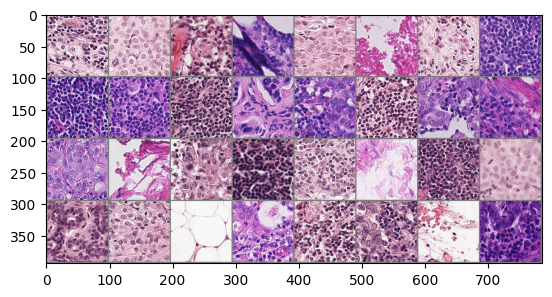

0     1     0     1     1     0     1     0     0     0     0     1     1     0     1     1     1     0     1     0     0     0     0     1     1     1     0     1     0     1     0     1    


In [6]:
classes = ('0', '1')
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [7]:
from torch.utils.data import random_split
torch.manual_seed(12345)
total_size = len(train_data)
print("total size =",total_size)
train_size = int(total_size * 0.7)
test_size = int(total_size * 0.15)
val_size = total_size - train_size - test_size
train_dataset, val_dataset, test_dataset = random_split(train_data, [train_size, test_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
print("train size=",len(train_dataset))

total size = 220025
train size= 154017


In [8]:
# Place this function at the beginning of your notebook
def conv_output_size(input_size, filter_size, stride=1, padding=0, pool_filter=2, pool_stride=2):
    output_size = (input_size - filter_size + 2 * padding) / stride + 1
    output_size = (output_size - pool_filter) / pool_stride + 1
    return int(output_size)

# Use the function to calculate the input size for fc1
input_size = 180  # Assuming this is your image size
size_after_first_layer = conv_output_size(input_size, 5)
size_after_second_layer = conv_output_size(size_after_first_layer, 5)

# Update this value in your Net class
fc1_input_size = 16 * size_after_second_layer * size_after_second_layer

In [17]:
class Net(nn.Module):
    ''' Models a simple Convolutional Neural Network'''

    def __init__(self):
        ''' initialize the network '''
        super(Net, self).__init__()
        # 3 input image channel, 6 output channels, 5x5 square convolution kernel
        self.conv1 = nn.Conv2d(3, 6, 5)
        # Max pooling over a (2, 2) window
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # Corrected input size for the first fully connected layer
        self.fc1 = nn.Linear(16 * 21 * 21, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)  # Two output units for binary classification

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 21 * 21)  # Corrected view operation
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
class double_conv2d_bn(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=3,strides=1,padding=1):
        super(double_conv2d_bn,self).__init__()
        self.conv1 = nn.Conv2d(in_channels,out_channels,
                               kernel_size=kernel_size,
                              stride = strides,padding=padding,bias=True)
        self.conv2 = nn.Conv2d(out_channels,out_channels,
                              kernel_size = kernel_size,
                              stride = strides,padding=padding,bias=True)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
    
    def forward(self,x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        return out
    
class deconv2d_bn(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=2,strides=2):
        super(deconv2d_bn,self).__init__()
        self.conv1 = nn.ConvTranspose2d(in_channels,out_channels,
                                        kernel_size = kernel_size,
                                       stride = strides,bias=True)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
    def forward(self,x):
        out = F.relu(self.bn1(self.conv1(x)))
        return out

class Unet(nn.Module):
    def __init__(self):
        super(Unet,self).__init__()
        self.layer1_conv = double_conv2d_bn(3,8)
        self.layer2_conv = double_conv2d_bn(8,16)
        self.layer3_conv = double_conv2d_bn(16,32)
        self.layer4_conv = double_conv2d_bn(32,64)
        self.layer5_conv = double_conv2d_bn(64,128)
        self.fc1 = nn.Linear(4608, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self,x):
        conv1 = self.layer1_conv(x)
        pool1 = F.max_pool2d(conv1,2) 
        
        conv2 = self.layer2_conv(pool1)
        pool2 = F.max_pool2d(conv2,2) 
        
        conv3 = self.layer3_conv(pool2)
        pool3 = F.max_pool2d(conv3,2) 
        
        
        conv5 = pool3.view(pool3.size(0), -1)
        conv5 = self.fc1(conv5)
        conv5 = self.fc2(conv5)
        conv5 = self.fc3(conv5)
        return conv5
unet = Unet()

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(unet.parameters(), lr=0.001, momentum=0.9)

In [19]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = unet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,   200] loss: 0.482
[1,   400] loss: 0.432
[1,   600] loss: 0.416
[1,   800] loss: 0.393
[1,  1000] loss: 0.403
[1,  1200] loss: 0.393
[1,  1400] loss: 0.378
[1,  1600] loss: 0.377
[1,  1800] loss: 0.392
[1,  2000] loss: 0.367
[1,  2200] loss: 0.376
[1,  2400] loss: 0.363
[1,  2600] loss: 0.359
[1,  2800] loss: 0.358
[1,  3000] loss: 0.366
[1,  3200] loss: 0.357
[1,  3400] loss: 0.358
[1,  3600] loss: 0.351
[1,  3800] loss: 0.357
[1,  4000] loss: 0.335
[1,  4200] loss: 0.343
[1,  4400] loss: 0.351
[1,  4600] loss: 0.347
[1,  4800] loss: 0.339
[2,   200] loss: 0.346
[2,   400] loss: 0.341
[2,   600] loss: 0.325
[2,   800] loss: 0.333
[2,  1000] loss: 0.321
[2,  1200] loss: 0.333
[2,  1400] loss: 0.341
[2,  1600] loss: 0.331
[2,  1800] loss: 0.336
[2,  2000] loss: 0.327
[2,  2200] loss: 0.327
[2,  2400] loss: 0.319
[2,  2600] loss: 0.314
[2,  2800] loss: 0.334
[2,  3000] loss: 0.326
[2,  3200] loss: 0.318
[2,  3400] loss: 0.333
[2,  3600] loss: 0.306
[2,  3800] loss: 0.309
[2,  4000] 

In [20]:
# Specify model name
model_name = "unet_shallow_nrl.pth"
# Use torch.save to save the model state
torch.save(unet.state_dict(), f'C:/Users/yl0768/Desktop/project/{model_name}')

In [21]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
model1 = Unet()
model1.load_state_dict(torch.load('unet_shallow_nrl.pth'))
model1.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model1(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct / total}%')


Accuracy of the network on the test images: 91.16800484775034%


In [22]:
from torch.utils.data import DataLoader
import torch
from torchmetrics import Accuracy, Precision, Recall, F1Score

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
model1 = Unet()
model1.load_state_dict(torch.load('unet_shallow_nrl.pth'))
model1.eval()


accuracy = Accuracy(num_classes=1, average='none', task='binary')
precision = Precision(num_classes=1, average='none', task='binary')
recall = Recall(num_classes=1, average='none', task='binary')
f1_score = F1Score(num_classes=1, average='none', task='binary')

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model1(images)
        _, predicted = torch.max(outputs, 1)

        accuracy.update(predicted, labels)
        precision.update(predicted, labels)
        recall.update(predicted, labels)
        f1_score.update(predicted, labels)

acc = accuracy.compute()
prec = precision.compute()
rec = recall.compute()
f1 = f1_score.compute()

print(f'Accuracy of the network on the test images: {acc*100:.2f}%')
print(f'Precision: {prec:.2f}')
print(f'Recall: {rec:.2f}')
print(f'F1 Score: {f1:.2f}')

Accuracy of the network on the test images: 91.17%
Precision: 0.90
Recall: 0.88
F1 Score: 0.89
